## <center> Kaggle - Classification competition</center>

## <center>  Haitao Shang </center>

<span style="color:blue">
    At the beginning of the notebook we are going to group all the necessary imports for the classification.
</span>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from time import time
from pprint import pprint
from imblearn.over_sampling import SMOTE
from itertools import combinations 

import math

import warnings
warnings.simplefilter(action='ignore')

<span style="color:blue">
    The below piece of code is just to avoid the scroll in the subsequent plots, because there are going to be multiple figures with a number of rows, each row with a couple of plots
</span>

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Reading the files

<span style="color:blue">
    Read the file and print the shape of train and test datasets.<br>
    Check that both train and test datasets contain the same features with `constant` values. If that is the case, we could be able to remove those features from both datasets.<br>
    Also, we have confirmed that the train dataset does not contain any null value.<br>
    We identify the categorical features (`subject`, `phase`, `state`) and the output column (`output`).
</span>

In [3]:
# Read the csv file from disk
train_wearable_raw_df = pd.read_csv("train_data.csv")
test_wearable_raw_df = pd.read_csv("test_data.csv")

# Print the dimensions of the dataframe and the first rows to see that everything is OK
print("Shape of the train dataframe: " + str(train_wearable_raw_df.shape))
print("Shape of the test dataframe: " + str(test_wearable_raw_df.shape))
print("Does train dataset have null values? ", train_wearable_raw_df.isnull().values.any())

train_unique_count = train_wearable_raw_df.nunique()
test_unique_count = train_wearable_raw_df.nunique()

train_univalue_features = train_unique_count[train_unique_count == 1].index
test_univalue_features = test_unique_count[test_unique_count == 1].index

print("Do both dataframes have the same columns with 1 value? ", 
      train_univalue_features.equals(test_univalue_features))
print()

categorical_columns = ['subject', 'phase', 'state']
#categorical_columns = ['subject', 'state']
output_column = 'output'

print("Unique values of categorical  variables ", categorical_columns)
print()

non_xyz_columns = categorical_columns.copy()
non_xyz_columns.append(output_column)

for column in non_xyz_columns:
    print(train_wearable_raw_df[column].value_counts().sort_index())
    print()

Shape of the train dataframe: (4584, 670)
Shape of the test dataframe: (1732, 669)
Does train dataset have null values?  False
Do both dataframes have the same columns with 1 value?  True

Unique values of categorical  variables  ['subject', 'phase', 'state']

A    380
B    513
C    361
D    420
F    330
G    518
H    181
I    663
K    468
L    444
M    306
Name: subject, dtype: int64

1    1215
2    1063
3    1015
4    1291
Name: phase, dtype: int64

A     398
B    1502
C    2106
D     576
E       2
Name: state, dtype: int64

0     711
1    3873
Name: output, dtype: int64



<span style="color:blue">
    Above we can see that the `output` class is quite imbalanced, so we will have to put in place a strategy to overcome this problem, to avoid problems when predicting the test dataset.<br><br>
    Below we are showing plots by phase, to highlight that we also have to put in place a strategy to capture the potential interactions among the categorical features.
</span>

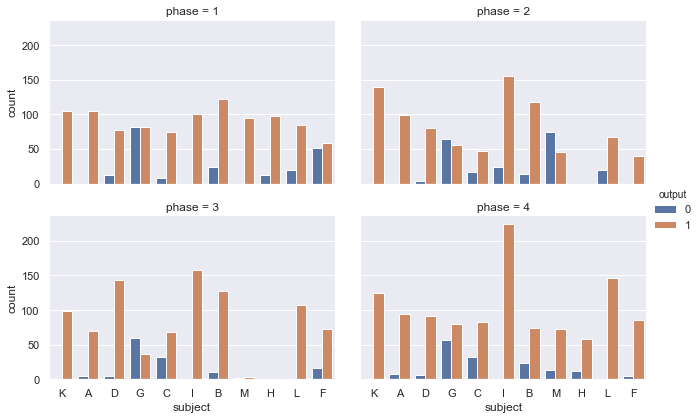

In [43]:
sns.factorplot(x="subject", hue="output", col="phase",
               data=train_wearable_raw_df, kind="count", col_wrap=2 , size=3, aspect=1.5);

# Building Transformer filters to implement feature selection

<span style="color:blue">
    The purpose of this class is to drop the features with constant values, as the add nothing to the model.<br>
    The class is a Transformer, so that it can be used within a pipeline.
</span>

In [4]:
class ConstantValueFilter(TransformerMixin, BaseEstimator):
    def __init__(self, debug=False):
        self.debug = debug

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Obtain the Series that contains the count of unique values per column
        unique_values_per_column_srs = X.nunique()
        # Filter to keep in the Series those columns with 1 value
        univalue_features_srs = unique_values_per_column_srs[unique_values_per_column_srs == 1].index
        # Drop the univalue columns from the dataframe
        X = X.drop(univalue_features_srs, axis=1)
        self.X = X
        
        if self.debug:
            print("CVF Called ", X.shape)
        
        return X

<span style="color:blue">
    The purpose of this class is to drop the features that have a correlation with the `output` variable below a given threshold.<br>
    The class is a Transformer, so that it can be used within a pipeline.
</span>

In [5]:
class CorrelationWithOutputSelector(TransformerMixin, BaseEstimator):
    def __init__(self, output_df, threshold = 0.01, debug=False):
        self.threshold = threshold
        self.output_df = output_df
        self.debug = debug

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        complete_df = X.join(self.output_df)
        
        corr_m = complete_df.corr()

        corr_m.output = abs(corr_m.output)
        corr_s = corr_m.output.sort_values()
        corr_filtered = corr_s[corr_s < self.threshold]
        low_correlated_with_output = corr_filtered.index   
        
        # Drop the univalue columns from the dataframe
        X = X.drop(low_correlated_with_output, axis=1)
        
        if self.debug:
            print("CWOS Called", X.shape)
            print("Low correlated = ", low_correlated_with_output)
        
        return X

<span style="color:blue">
    The purpose of this class to implement a `one hot encoding` for the categorical features of the dataset. This way, we are creating a new feature for each level within the categorical feature.<br>
    The class is a Transformer, so that it can be used within a pipeline
</span>

In [6]:
class OneHotEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, categorical_columns, debug=False):
        self.categorical_columns = categorical_columns
        self.debug = debug
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lb_style = LabelBinarizer()
        for column in categorical_columns:
            lb_results = lb_style.fit_transform(X[column])
           
            category_column_names = [column + '_' + str(class_name) for class_name in lb_style.classes_]
            category_df = pd.DataFrame(lb_results, columns=category_column_names)
            X = X.join(category_df)
            X = X.drop(column, axis=1)
        
        if self.debug:
            print("OHE Called", X.shape)
        
        return X

<span style="color:blue">
    The purpose of this class to scale all features and drop those with variance below a given threshold.<br>
    The optimal value of the threshold is going to be found through cross validation.<br>
    The class is a Transformer, so that it can be used within a pipeline.
</span>

In [7]:
class ScalerAndVarianceSelector(TransformerMixin, BaseEstimator):
    def __init__(self, threshold, debug=False):
        self.threshold = threshold
        self.debug = debug
        
    def variance_threshold_selector(self, data):
        selector = VarianceThreshold(self.threshold)
        selector.fit(data)
        return data[data.columns[selector.get_support(indices=True)]]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        min_max_scaler = MinMaxScaler()
        #min_max_scaler = RobustScaler()
        x_scaled = min_max_scaler.fit_transform(X)
        df = pd.DataFrame(x_scaled, columns=X.columns)
        
        Y = self.variance_threshold_selector(df)
        X = X[Y.columns]
        
        if self.debug:
            print("S&VTS Called", X.shape)
        
        return X

<span style="color:blue">
    The purpose of this class to calculate correlation among all features and drop whose correlation is above a given threshold.<br>
    The optimal value of the threshold is going to be found using cross validation.<br>
    The class can find correlation only among columns with a certain pattern in the name. This helps to find correlation only among the columns that begins with `x`, `y` or `z`.<br>
    The class is a Transformer, so that it can be used within a pipeline
</span>

In [8]:
class HighCorrelationSelector(TransformerMixin, BaseEstimator):
    def __init__(self, threshold, feature_pattern=None, debug=False):
        self.threshold = threshold
        self.feature_pattern = feature_pattern
        self.debug = debug
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):    
        # Create correlation matrix
        if type(X) is np.ndarray:
            X = pd.DataFrame(X)
        
        if self.feature_pattern == None:
            corr_matrix = X.corr().abs()

            # Select upper triangle of correlation matrix
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

            # Find index of feature columns with correlation greater than the threshold
            to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]

            X = X.drop(to_drop, axis=1)
            
            if self.debug:
                print("HC Called", X.shape)
        else:
            pattern_cols = [col for col in X.columns if self.feature_pattern in col]
            X_pattern = X[pattern_cols]
            X = X.drop(pattern_cols, axis=1)
            
            if self.debug:
                print((X_pattern.shape))
            
            corr_matrix = X_pattern.corr().abs()

            # Select upper triangle of correlation matrix
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

            # Find index of feature columns with correlation greater than the threshold
            to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]

            X_pattern = X_pattern.drop(to_drop, axis=1)
            
            if self.debug:
                print((X_pattern.shape))
            
            X = X.join(X_pattern)
        
        return X

<span style="color:blue">
    The purpose of this class to create new interaction features based on the interaction of the categorical features, once they have been transformed using One Hot Encoding.
</span>

In [9]:
class InteractionEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, categorical_columns, debug=False):
        self.categorical_columns = categorical_columns
        self.debug = debug
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #return X
        
        if self.debug:
            print("IE Input", X.shape)
        
        interaction_cols = []

        for col in X.columns:
            for cat_col in self.categorical_columns:
                if cat_col in col:
                    interaction_cols.append(col)

        interaction_pairs = list(combinations(interaction_cols, 2))

        for feature_par in interaction_pairs:
            key = feature_par[0] + "*" + feature_par[1]
            kwargs = {key : 
                      lambda x: x[feature_par[0]] * x[feature_par[1]]}
            X = X.assign(**kwargs)
        
        if self.debug:
            print("IE Output", X.shape)
            
        return X

<span style="color:blue">
    Class to select features based on Random Forest importance.
</span>

In [10]:
class RandomForestSelector(TransformerMixin, BaseEstimator):
    def __init__(self, threshold, debug=False):
        #classifier = RandomForestClassifier(n_estimators=100, random_state=0)
        classifier = RandomForestClassifier(**get_RF__feature_sel_parameters(), random_state=0)
        self.debug = debug
        
        self.select_from_model = SelectFromModel(classifier, threshold=threshold)
        
    def fit(self, X, y=None):  
        self.select_from_model.fit(X, y)
        return self

    def transform(self, X):
        x_transformed = self.select_from_model.transform(X)
        
        selected_columns = self.select_from_model.get_support(indices=True)
        selected_columns_names = X.columns[selected_columns]
        
        df = pd.DataFrame(x_transformed, columns=selected_columns_names)
        
        self.selected_columns_names_ = selected_columns_names
        
        if self.debug:
            print("RFS Called", df.shape)
        
        return df

# Tuning hyperparameters for classification methods

<span style="color:blue">
    Below are a group of functions that have been used to find the optimal values for the parameter for all the classification methods explored.
</span>

### Random Forest, just as selector of important features

<span style="color:blue">
    The below function is used to tune the parameters for a RandomForest method used only to identify the most important features of the training dataset.
</span>

In [11]:
def get_RF__feature_sel_parameters():
    parameters = { 
        'n_estimators': 250,
        #'criterion': 'entropy',
        'max_depth': 50,
        'class_weight':'balanced_subsample',
        'class_weight':{0:0.95, 1:0.05},
        #'min_samples_split': 0.625,
        #'min_samples_leaf': 0.1,
        'max_features': 50,
        #'oob_score': False,
        }
    return parameters

### Linear Discriminant Analysis

<span style="color:blue">
    The below function is used to tune the parameters for a Linear Discriminant Analysis classification method. Following are the parameters used:<br>    
-n_components: number of components for dimensionality reduction. For the given dataset, a smaller value for “n_component” generates a better classification result. The optimal value we found for “n_component” in LDA method is “None”.<br><br>
-Priors: prior probabilities of the classes. If specified the priors are not adjusted according to the data. For the given dataset, a smaller value for “Priors” generates a better classification result. The optimal value we found for “Priors” in LDA method is “None”.<br><br>
-Solver: there are three types of “Solver” available in LDA – “svd”: Singular value decomposition, “lsqr”: Least squares solution, and “eigen”: Eigenvalue decomposition. Here we found that optimal “Solver” is “lsqr”.<br><br>
-Shrinkage：A tool to improve estimation of covariance matrices in situations where the number of training samples is small compared to the number of features. For the given dataset here, “auto” is optimal type of shrinkage.
</span>

In [12]:
def get_LDA_parameters():
    parameters = {  'n_components': [None, 1, 5, 10, 15],
                    'priors': [None],
                    'solver': ['lsqr'],
                    'shrinkage': [None, 'auto']
                      }
    return parameters

### Quadratic Discriminant Analysis

<span style="color:blue">
    The below function is used to tune the parameters for a Quadratic Discriminant Analysis classification method. Following are the parameters used in the classification:<br><br>
-reg_param: used to regularize the covariance estimate. We tried four different values (0.1, 0.01, 0.00001, and 0.0001) and found that 0.01 is the optimal value.<br><br>
-store_covariance: if the value is “True” the covariance matrices are computed and stored in the self.covariance_ attribute. For the given dataset, the optimal value for “store_covariance” is “True”.<br><br>
-tol: threshold used for rank estimation. For the given dataset, a smaller value for “tol” generates a better classification result. Among the four values we tried -- 0.1, 1, 5, and 10, in which 0.1 is the optimal value for “tol”.
</span>

In [13]:
def get_QDA_parameters():
    parameters = {  'reg_param': [0.1, 0.01, 0.00001, 0.0001],
                    'store_covariance': [True, False],
                    'tol': [0.1, 1, 0.5, 10],
                }
    return parameters

### Random Forest

<span style="color:blue">
    The below function is used to tune the parameters for a Random Forest classification method. This function is different from `get_RF__feature_sel_parameters` (remember `get_RF__feature_sel_parameters` was used to tune a random forest just to evaluate the importance of the features, and keep the most important). The below function actually is used for classification, and that is why it uses a lot more parameters. Let's explain them:<br><br>
-n_estimators: the number of trees in the forest. Here we tried several different values for “n_estimators” and found that 50 is the optimal value.<br><br>
-criterion: the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. For the given dataset, “gini” generates a better classification result than “entropy”.<br><br>
-class_weight: Weights associated with classes. Three different values are tried here: 'balanced_subsample', 'balanced_subsample', and “None”. We found that the value “balanced_subsample” generates the optimal result.<br><br> 
-max_features: The number of features to consider when looking for the best split. We found that, for the given dataset, a smaller value for the “max_feature” produces a better classification result. Am0ng the values we have attempted, the optimal value is 50.
</span>

In [14]:
def get_RF_parameters():
    parameters = { 
        'n_estimators': [100],
        'criterion': ['gini'],
        'max_depth': np.linspace(100, 100, 1, endpoint=True),
        'class_weight':['balanced_subsample'],
        #'class_weight':[{0:0.85, 1:0.15}],
        'min_samples_split': np.linspace(0.625, .625, 1, endpoint=True),
        'min_samples_leaf': np.linspace(0.0555555, 0.05555555, 1, endpoint=True),
        'max_features': list(range(50,51,1)),
        'oob_score': [False],
        }
    return parameters 

### Support Vector Classifier

<span style="color:blue">
    The below function is used to tune the parameters for a Suppor Vector Classifier  method.<br>
    After trying a significant number of combinations, the performance of the method is really poor, so we have ruled out its use here.
</span>

In [15]:
def get_SVM_kernel_parameters():
    parameters = { 
        'kernel':['linear'],
        'probability': [True],
        'class_weight' : ['balanced'],
        'verbose': [True],
        #'gamma': [0.1, 1, 10, 100]
        #'c' = [0.1, 1, 10, 100, 1000],
        #'degree' = [0, 1, 2, 3, 4, 5, 6]
        }
    return parameters 

def get_SVM_parameters():
    parameters = { 
        #'kernel':['linear'],
        #'degree': [1],
        #'probability': [True],
        #'class_weight' : ['balanced'],
        #'verbose': [True],
        #'cache_size': [7000]
        #'gamma': [0.1, 1, 10, 100]
        #'c' = [0.1, 1, 10, 100, 1000],
        #'degree' = [0, 1, 2, 3, 4, 5, 6]
        }
    return parameters 

### K-Nearest Neighbors

<span style="color:blue">
    The below function is used to tune the parameters for a KNN classification method. The parameters being used in the classification were:<br><br>
-n_neighbors: number of neighbors to get. We tried several different values for “n_neighbors”, it turned out that the optimal value is 50.<br><br>
-metric: the distance metric to use for the tree. we tried two different metrics -- 'hamming' and "euclidean" and found that “hamming” is best classification method.
</span>

In [16]:
def get_KNN_parameters():
    parameters = {
         'n_neighbors': list(range(25,26,1)),
         'metric': ['hamming'],
         'weights': ['distance'],
         #'leaf_size': list(range(1,10,1)), 
         #'algorithm' : ['kd_tree'],
         'p': list(range(3,4,1))
        }
    return parameters

### Linear Regression

<span style="color:blue">
    The below function is used to tune the parameters for a Logistic Regression classification method. Here is the results:<br><br>
-tol: tolerance for stopping criteria. For the given dataset, a smaller value for “tol” generates a better classification. Among the four values we tried -- 0.0005, 0.001, 0.01, and 0.1, the value “0.0005” produces the best result.<br><br>
-C: inverse of regularization strength. For the given dataset, a smaller value for “C” generates a better classification. Among the three values we tried -- 0.5, 1, and 5, the value “0.5” produces the best result.<br><br> 
-solver: the Algorithm to use in the optimization problem. We tried three different solvers for the dataset, including “liblinear”, “sag”, and “saga”. It turned out that the solver “liblinear” generates the best classification result.
</span>

In [17]:
def get_LR_parameters():
    parameters = {'tol': np.linspace(.00005, .00005, 1, endpoint=True), # smaller takes longer to converge
                  'C': np.linspace(.3, .3, 1, endpoint=True),
                  #'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],
                  'solver': ['liblinear'],
        }
    return parameters

### Decision Trees

<span style="color:blue">
    The below function is used to tune the parameters for a Decision Tree classification method. The most important parameters used are:<br><br>
-criterion: the function to measure the quality of a split. We tried two criteria, including “gini” and “entropy”. It turned out that 'gini' produces a better classification result. <br><br>
-splitter: the strategy used to choose the split at each node. We tried two methods – “best” and “random” to classify the given dataset and found that “random” gives us a better result than “best”. <br><br>
-min_samples_leaf: the minimum number of samples required to be at a leaf node. We tried several different values and found that the classification result increases with the increase in the value of “min_samples_leaf”. The optimal value for “min_samples_leaf” we found is 1.<br><br> 
-min_weight_fraction_leaf: the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. We tried several different values and found that the classification result increases with the increase in the value of min_weight_fraction_leaf”. The optimal value for “min_weight_fraction_leaf” we found is 0.05
</span>

In [18]:
def get_DT_parameters():                        
    parameters = {'criterion': ['gini'],
                  'splitter': ['random'],
                  'min_samples_leaf': list(range(12,13,1)),
                  'min_weight_fraction_leaf': np.linspace(.005, .005, 1, endpoint=True),
                  #'max_features': list(range(200,201,1)),
                  'max_depth': list(range(30,31,1)),
                  'max_features': list(range(85,86,1)),
                  'min_impurity_decrease': np.linspace(3.3e-07, 3.3e-07, 1, endpoint=True),
        }
    return parameters

### XGBoost

<span style="color:blue">
    The below function is used to tune the parameters for a XGBoost classification method. For XGBoost method, we tried many different values for the following parameters and only demonstrate the optimal values that can generate the best result among all of the classification results we have obtained:<br><br>
-n_estimators: the number of trees.<br><br>
-colsample_bylevel: subsample ratio of columns for each split, in each level.<br><br> 
-colsample_bytree: subsample ratio of columns when constructing each tree.<br><br>
-reg_lambda: regularization term on weights. Increasing this value will make model more conservative.<br><br>
-scale_pos_weight: control the balance of positive and negative weights, useful for unbalanced classes.<br><br>
-eta: step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
-min_child_weight: minimum sum of instance weight (hessian) needed in a child.<br><br> 
-max_depth: maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit<br><br>
-gamma: minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.<br><br>
-eval_metric: evaluation metrics for validation data, a default metric will be assigned according to objective.
</span>

In [19]:
def get_XGB_parameters():
    parameters = { 
        'n_estimators': [2000],
        'colsample_bylevel': np.linspace(.8, .8, 1, endpoint=True),
        'colsample_bytree': np.linspace(.7, .7, 1, endpoint=True),
        'learning_rate': np.linspace(0.049888888888888885, 0.049888888888888885, 1, endpoint=True),
        'reg_lambda': np.linspace(.1, .1, 1, endpoint=True),
        'scale_pos_weight': np.linspace(0.18357862, 0.18357862, 1, endpoint=True),
        'eta': np.linspace(.85, .85, 1, endpoint=True),
        'min_child_weight': np.linspace(.621, .621, 1, endpoint=True),
        'max_depth': list(range(250,260,1)),
        'gamma': np.linspace(.6, .6, 1, endpoint=True),
        #'objective': ['rank:ndcg'],
        'eval_metric': ['auc'],
        #'booster': ['gblinear']
        }
    return parameters 

<span style="color:blue">
    Function to separate the training dataset into the predictor features and the output. 
</span>

In [20]:
def get_X_Y(total_df, output_column):
    Y_df = total_df[output_column]
    Y = Y_df.values

    X_df = total_df.drop(output_column, axis=1)
    X = X_df.values
    
    return X, X_df, Y, Y_df

# Performing feature selection

<span style="color:blue">
    Below is the main function to perform the feature selection. It is based on a pipeline of 10 steps that are chained one after the other. Below is a high level explanation of the process steps:<br><br>
0) From the train dataset, we obtain the individual features and the output variable (in array and DataFrame formats).<br>
1) `A One Hot Enconder` (OHE) is applied for the categorical features, creating a new feature for each factor level in a categorical variable.<br>
2) After that, an `Interaction filter` is applied to all the new features resulting from the OHE of the categorical features. This interaction is created to take into account potential interactions between any pair of features. We are not using the x's, y's or z's variables for that.<br>
3) A `Constant Value filter` is applied, to remove all the variables with unique values, that would add nothing to the model.<br>
4) A `Scaler Variance selector` is applied: first of all, all the features are temporarily scaled (we are not transforming the variables to a scale, just temporal). After that, we remove those variables whose individual variance is below a certain threshold. The optimal value of the threshold is going to be determined through cross validation.<br>
5) A `High Correlation filter` is applied for the x's variables (that is, all the features starting with an `x`). This filter tries to look for high correlation of variables in the same axis, and remove those that are highly correlated with the other (within the same axis). There is a threshold that will determine what variables are to be removed. The threshold is going to be determined thru cross validation.<br>
6) Same as 5, but with y's variables.<br>
7) Same as 5, but with z's variables.<br>
8) A last step of high correlation is done, but now with the remaining variables from steps 1) thru 7).<br>
9) A `Correlation with output filter` is applied, meaning that we are going to remove those features poorly correlated with the output variable, using a given threshold. The threshold is going to be determined via cross validation.<br>
10) The last step is a `Random Forest feature importance filter`, in which we are going to remove those features that a Random forest classifier deems to be less important. The threshold is going to be determined through cross validation.<br><br>
To sum it up, there are 4 thresholds:<br>
a) Threshold for the minimum variance of an individual feature.<br>
b) Threshold for the maximum correlation among a group of features (x's, y's, z's and all).<br>
c) Threshold for the minimum correlation of an individual feature with the output.<br>
d) Threshold for the minimum importance of a feature using a Random Forest selector.
</span>

In [21]:
def feature_selection(raw_df, scaler_variance_threshold, random_forest_threshold, correlation_threshold,
                      output_corr_threshold, categorical_columns, output_column, debug=False):
    
    X, X_df, Y, Y_df = get_X_Y(raw_df, output_column)

    # Column names and types of X
    feature_columns = X_df.columns
    column_types = X_df.dtypes

    wearable_pipeline = Pipeline([
        ('one_hot_encoder', OneHotEncoder(categorical_columns, debug)),
        ('interaction_encoder', InteractionEncoder(categorical_columns, debug)),
        ('constant_value_filter', ConstantValueFilter(debug)),
        ('scaler_variance_selector', ScalerAndVarianceSelector(scaler_variance_threshold, debug)),
        ('high_correlation_selector_x', HighCorrelationSelector(correlation_threshold, feature_pattern="x", 
                                                                debug=debug)),
        ('high_correlation_selector_y', HighCorrelationSelector(correlation_threshold, feature_pattern="y", 
                                                                debug=debug)),
        ('high_correlation_selector_z', HighCorrelationSelector(correlation_threshold, feature_pattern="z", 
                                                                debug=debug)),
        ('high_correlation_selector', HighCorrelationSelector(correlation_threshold, debug=debug)),
        ('correlation_with_output_selector', CorrelationWithOutputSelector(Y_df, output_corr_threshold, debug)),
        ('random_forest_selector', RandomForestSelector(random_forest_threshold, debug))
    ])

    filtered_df = wearable_pipeline.fit_transform(X_df, Y)
    
    return filtered_df.join(Y_df)
    #return filtered_df
    

<span style="color:blue">
    Function to split a dataset into predictors and output, in two formats: array and DataFrame.
</span>

In [22]:
def split_train_test_df(total_df, output_column):
    
    X, X_df, Y, Y_df = get_X_Y(total_df, output_column)

    # Column names and types of X
    feature_columns = X_df.columns
    column_types = X_df.dtypes

    # Split the dataset into train and test matrix
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=101)

    # Convert the train and test matrix into a dataframes
    X_train_df = pd.DataFrame(X_train, columns=feature_columns)
    X_train_df = X_train_df.astype(column_types)

    X_test_df = pd.DataFrame(X_test, columns=feature_columns)
    X_test_df = X_test_df.astype(column_types)
    
    return X_train_df, X_test_df, y_train, y_test

<span style="color:blue">
    Function to stablish a manual cutoff of class `1` or `0` different than 0.5.<br>
    Eventually we have not used a different cutoff, but this was helpful to see the effect of having a different cutoff.
</span>

In [23]:
def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:,1] > cutoff).astype(int)

<span style="color:blue">
    Function to plot the ROC curve given fpr and tpr arrays. This was actually used only for testing purposes. The plot functions are at the end of the notebook.
</span>

In [24]:
def plot_ROC(fpr, tpr, title):
    plt.plot(fpr, tpr, lw=1, label='ROC')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show() 

# Executing classification methods

<span style="color:blue">
    Below is the main function to test all the classification methods in this HW. The classification methods that have been tested are:<br>
    1) Linear Discriminant Analysis (`LDA` tag in the function below).<br>
    2) Quadratic Discriminant Analysis (`QDA` tag in the function below).<br>
    3) Random Forest (`RF` tag in the function below).<br>
    4) Support Vector Classifier (`SVC` tag in the function below).<br>
    5) K-Nearest Neighbors (`KNN` tag in the function below).<br>
    6) Linear Regression (`LR` tag in the function below).<br>
    7) Decision Trees (`DT` tag in the function below).<br>
    8) XGBoost (`XGB` tag in the function below).<br><br>
The process followed to test a classification method has been the same, to try to standardize the process and be able to include as much methods as possible. <br>
Below are the main steps followed:<br>
    1) We have used the Synthetic Minority Over-sampling Technique (SMOTE) to overcome the imbalanced nature of the training dataset, consisting generating synthetic samples thru randomly sampling the attributes from instances in the minority class. Basically we have oversampled the training dataset.<br>
    2) With the resulting DataFrames, we are going to work.<br>
    3) We get the hyperparameters of the given classification method. There is a function per each method, and the function was explained before. The final version of the function does not have all the ranges used in the parameters, because we need to generate a final execution of the notebook. But we have spend quite some time tuning the parameters of each function until we found the optimal combination for this dataset.<br>
    4) We implement cross validation using GridSearchCV, and using as scoring the `roc_auc` metric.<br>
    5) With the `best combination of parameters`, we fit a model.<br>
    6) We calculate the predictions using the best model, using a random split of the dataset into train and test.<br>
    7) We obtain different metrics: accuracy, precision, recall, tpr, fpr, F1, roc_auc.<br> 
    8) We write a file with all the information of the best combination of parameters.<br>
    9) We return the best classifier and all the parameters of the execution.
</span>

In [25]:
# Function to test a classifier using different parameters
# It returns a classifier to be used afterwards to make predictions 
def test_classification_method(data, categorical_columns, output_column, method, cutoff, thres_conf, debug=False):
    
    t0 = time()
    
    X_train_df, X_test_df, y_train, y_test = split_train_test_df(data, output_column)
    
    sm = SMOTE(random_state=12, ratio = 1.0)
    x_train_res, y_train_res = sm.fit_sample(X_train_df, y_train)
    
    X_train_df = pd.DataFrame(x_train_res, columns=X_train_df.columns)
    y_train = y_train_res
    
    if method == 'LDA':
        parameters = get_LDA_parameters()
        clf = LinearDiscriminantAnalysis()
    elif method == "QDA":
        parameters = get_QDA_parameters()
        clf = QuadraticDiscriminantAnalysis()
    elif method == "RF":
        parameters = get_RF_parameters()
        clf = RandomForestClassifier(random_state=82)
    elif method == "XGB":
        parameters = get_XGB_parameters()
        clf = xgb.XGBClassifier(seed=82)
    elif method == "SVM":
        parameters = get_SVM_kernel_parameters()
        clf = SVC(random_state=82)
    elif method == "KNN":
        parameters = get_KNN_parameters()
        clf = KNeighborsClassifier()       
        #X_train_df = pd.DataFrame(normalize(X_train_df), columns=X_train_df.columns)
    elif method == "LR":
        parameters = get_LR_parameters()
        clf = LogisticRegression(random_state=82)
    elif method == "DT":
        parameters = get_DT_parameters()
        clf = DecisionTreeClassifier(random_state=82)
    else:
        raise RuntimeError('Method not supported')

    CV_clf = GridSearchCV(clf, parameters, cv=5, n_jobs=-1, scoring='roc_auc')

    # Fit and tune model
    CV_clf.fit(X_train_df, y_train)
    
    if method == 'LDA':
        best_clf = LinearDiscriminantAnalysis(**CV_clf.best_params_)
    elif method == 'QDA':
        best_clf = QuadraticDiscriminantAnalysis(**CV_clf.best_params_)
    elif method == "RF":
        best_clf = RandomForestClassifier(**CV_clf.best_params_, random_state=82)
    elif method == "XGB":
        best_clf = xgb.XGBClassifier(**CV_clf.best_params_, seed=82)
    elif method == "SVM":
        best_clf = SVC(**CV_clf.best_params_, random_state=82)
    elif method == "KNN":
        best_clf = KNeighborsClassifier(**CV_clf.best_params_)
    elif method == "LR":
        best_clf = LogisticRegression(**CV_clf.best_params_, random_state=82)
    elif method == "DT":
        best_clf = DecisionTreeClassifier(**CV_clf.best_params_, random_state=82)
    else:
        raise RuntimeError('Method not supported')

    best_clf.fit(X_train_df,y_train)

    probas_ = best_clf.predict_proba(X_test_df)

    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])

    roc_auc = auc(fpr, tpr)
    
    #prediction = best_clf.predict(X_test_df)
    prediction = cutoff_predict(best_clf,X_test_df, cutoff)
    
    f1 = f1_score(y_test,prediction)  
    acc_score = accuracy_score(y_test, prediction)
    
    confusion_matrix = metrics.confusion_matrix(y_test, prediction)
    pre_score = precision_score(y_test, prediction)
    re_score = recall_score(y_test, prediction)
    
    prec_c, recall_c, thre_pc = precision_recall_curve(y_test, probas_[:, 1])
    
    if debug:
        plot_ROC(fpr, tpr, method + " ROC")

    if debug:
        print("Accuracy score = ", acc_score)
        print("F1 = ", f1)
        print("ROC AUC = ", roc_auc)
        print()
    
    b_params = CV_clf.best_params_
    
    lapse = time() - t0
    strTime = "{}".format(datetime.timedelta(seconds=lapse))

    b_params.update({'Time': strTime})
    b_params.update({'Lapse': lapse})
    b_params.update(thres_conf)
    b_params.update({'Cutoff': cutoff})
    b_params.update({'Accuracy score': acc_score})
    b_params.update({'F1': f1})
    b_params.update({'Best score': CV_clf.best_score_})
    b_params.update({'AUC': roc_auc})
    
    b_params.update({'conf_matrix': confusion_matrix})
    b_params.update({'fpr': fpr})
    b_params.update({'tpr': tpr})
    b_params.update({'prec_score': pre_score})
    b_params.update({'recall_score': re_score})
    
    b_params.update({'prec_c': prec_c})
    b_params.update({'recall_c': recall_c})
    b_params.update({'thre_pc': thre_pc})
   

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%I%M%S%p")
    str_roc_auc = "%.5f" % roc_auc
    
    b_params.update({'str_roc_auc': str_roc_auc})
    
    file_name = method +'_' + str_roc_auc + '_' + timestamp +'.txt'

    with open(file_name, 'w') as f:
        for key, value in b_params.items():
            f.write('%s:%s\n' % (key, value))
        
    f.close()
    
    if debug:
        pprint(b_params)
    
    return best_clf, b_params

<span style="color:blue">
    Function to execute a prediction using the best classifier computed in the previous function, and using the test dataset provided.<br><br>
    The tricky part of this function is to include, in the test dataset, all the categorical features and also all the interaction features created while doing the `feature_selection` function, and then remove the ones filtered during the selection process.<br>
    Finally, the function creates the file with the prediction, using the required format. The name of the file includes:<br>
    1) The classification method.<br>
    2) The roc_auc value obtained with the train dataset.<br>
    3) In parenthesis, the proportion of the 0/1 classes in the prediction (as a reference).<br>
    4) The timestamp.
</span>

In [26]:
def write_prediction(filtered_df, test_df, best_clf, categorical_columns, output_column, suffix, cutoff, roc_auc):
    ohe = OneHotEncoder(categorical_columns)
    X_test_OHE_df = ohe.transform(test_df)
    
    ie = InteractionEncoder(categorical_columns)
    X_test_OHE_df = ie.transform(X_test_OHE_df)
    
    filtered_df = filtered_df.drop(output_column, axis=1)

    #columns selected by feature selection
    X_test_OHE_df = X_test_OHE_df[filtered_df.columns.tolist()]

    #y_pred = best_clf.predict(X_test_OHE_df)
    #y_pred = cutoff_predict(best_clf,X_test_OHE_df,cutoff)
    preds = best_clf.predict_proba(X_test_OHE_df)
    
    c_p = preds[preds[:,1]<cutoff]
    ratio = "%.3f" % (len(c_p)/preds.shape[0]) 

    # Convert the train and test matrix into a dataframes
    #Y_pred_df = pd.DataFrame(y_pred, columns=['output'])
    #Y_pred_df.index.names = ['id']
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%I%M%S%p")
    
    file_name = suffix + '_prediction_' + roc_auc + '_(' + ratio + ')_'+ timestamp + '.csv'
    print("Writing file: " + file_name)
    
    #Y_pred_df.to_csv(file_name)
    
    submithis = pd.DataFrame([test_df.index,preds[:,1]]).T
    submithis.columns = ['id','output']
    submithis.id = submithis.id.astype(int)
    submithis.to_csv(file_name,index=False)


## Selecting the best thresholds for the feature selection

<span style="color:blue">
   Function to find the best combination for the `4 thresholds` that determines the behavior of the feature selection in the process.<br>
   We are establishing ranges of values for the 4 thresholds and execute in sequence the `feature_selection` and `test_classification_method` to come up with the best roc_auc metric.<br>
   The function returns an array with all the scores obtained, and we will pick the thresholds with the best performance using the roc_auc.<br>
   The details for the `feature_selection` and `test_classification_method` were explained before in the notebook.<br><br>
   We have executed this function over and over again to come up with the best combination of thresholds.<br><br>
   This function uses Random Forest as default method to determine the best combination. Random Forest offers the best balance between significance of results and performance. We needed an algorithm that is significant enough, but that it does not take very long to test.
</span>

In [27]:
def threshold_selection(data, categorical_columns, output_column, debug=False):
 
    #scaler_variance_threshold = 0.00073 # greater reduces features  
    #correlation_threshold = 0.959 # lower reduces features
    #random_forest_threshold = 0.000245 # greater reduces features
    
    #Very Best score =  (0.00073, 0.000245, 0.959, 0.0001, '0.77783', 326)

    scaler_variance_threshold = np.linspace(0.00070, 0.00070, 1, endpoint=True) # greater reduces features  
    correlation_threshold = np.linspace(0.94, 0.94, 1, endpoint=True) # lower reduces features
    random_forest_threshold = np.linspace(0.00026, 0.00026, 1, endpoint=True) # greater reduces features
    output_corr_threshold = np.linspace(.00001, .0001, 50, endpoint=True) # greater reduces features
    cut = 0.5

    scores = []
    for v_threshold in scaler_variance_threshold:
        for c_threshold in correlation_threshold:
            for r_threshold in random_forest_threshold:
                for o_threshold in output_corr_threshold:

                    t_ini = time()

                    f_s_df = feature_selection(data, 
                                               v_threshold, r_threshold, c_threshold, 
                                               o_threshold, categorical_columns, output_column, debug)

                    t_conf = {'sc_t': v_threshold, 'rf_t': r_threshold, 
                      'corr_t':c_threshold, 'features': f_s_df.shape[1], 'ouput_t': o_threshold}

                    best_classifier, bparams = test_classification_method(f_s_df, categorical_columns, 
                                                        output_column, "RF", cut, t_conf, debug=False)
                    lapse = time() - t_ini
                    str_lapse = "{}".format(datetime.timedelta(seconds=lapse))

                    print('Lapse by iteration = ', str_lapse)
                    if debug:
                        print('Number of features = ', f_s_df.shape[1])
                        print('scaler_variance_threshold = ', v_threshold)
                        print('random_forest_threshold = ', r_threshold)
                        print('correlation_threshold = ', c_threshold)
                        print('AUC = ', bparams['str_roc_auc'])
                        print()

                    scores.append(tuple((v_threshold, r_threshold, c_threshold, o_threshold, 
                                         bparams['str_roc_auc'], f_s_df.shape[1])))

    return scores

<span style="color:blue">
    Function to execute the threshold selection, using the above function, and selecting the best combination from the ordered list of scores obtained.<br>
    Considering the results of this process, we are executing a definitive feature selection to run all the classification methods.
</span>

In [28]:



#scores = threshold_selection(train_wearable_raw_df, categorical_columns, output_column, False)

#sorted_by_auc = sorted(scores, key=lambda tup: tup[4], reverse=True)

#print('Best score = ', sorted_by_auc[0])

<span style="color:blue">
    Function to execute a definitive feature selection, considering the best thresholds obtained from the `threshold_selection` function.<br>
    This chunk of code will give us a filtered dataset to test all the classification methods for a final run!<br>
    Applying out feature selection strategy, we have reduced the number of features to 325!
</span>

In [29]:
#Very Best =  (0.00073, 0.000245, 0.959)

#Best score =  (0.0007, 0.00026, 0.94, 0.0001, '0.76814', 293)

scaler_variance_threshold = 0.00073 # greater reduces features  
correlation_threshold = 0.959 # lower reduces features
random_forest_threshold = 0.000245 # greater reduces features
output_corr_threshold = 0.0000385

cutoff = 0.5

featured_df = feature_selection(train_wearable_raw_df, 
                                scaler_variance_threshold, 
                                random_forest_threshold, 
                                correlation_threshold, 
                                output_corr_threshold,
                                categorical_columns, output_column, True)

thresholds = {'sc_t': scaler_variance_threshold, 'rf_t': random_forest_threshold, 
              'corr_t':correlation_threshold, 'features': featured_df.shape[1], 'output_t':output_corr_threshold}

OHE Called (4584, 686)
IE Input (4584, 686)
IE Output (4584, 876)
CVF Called  (4584, 684)
S&VTS Called (4584, 636)
(4584, 175)
(4584, 101)
(4584, 170)
(4584, 94)
(4584, 171)
(4584, 95)
HC Called (4584, 410)
CWOS Called (4584, 408)
Low correlated =  Index(['x218', 'y41'], dtype='object')
RFS Called (4584, 324)


<span style="color:blue">
    The below chunk of code executes the classification method function using `XGBoost`, that is has proven to be the best in terms of roc_auc metric compared to the others. It returns a model, `best_classifier`, and uses it to run a prediction using the provided test dataset.<br> 
</span>

In [30]:
best_classifier, bparams = test_classification_method(featured_df, categorical_columns, output_column, 
                                                      "XGB", cutoff, thresholds, debug=False)

write_prediction(featured_df, test_wearable_raw_df, 
                 best_classifier, categorical_columns, output_column, "XGB", cutoff, bparams['str_roc_auc'])

Writing file: XGB_prediction_0.87346_(0.172)_20181105_075225PM.csv


# Comparing methods

<span style="color:blue">
    The below chunk of code executes the classification method function using `XGBoost`, that is has proven to be the best in terms of roc_auc metric compared to the others. It returns a model, `best_classifier`, and uses it to run a prediction using the provided test dataset.<br> 
</span>

In [31]:
methods = ['LDA', 'QDA', "RF", "KNN", "LR", "DT", "XGB" ]

def execute_classification_methods(data, categorical_columns, output_column, cutoff, thresholds):
    method_dict = {}
    for method in methods:
        best_classifier, bparams = test_classification_method(
                                                              data, categorical_columns, 
                                                              output_column, 
                                                              method, cutoff, thresholds, debug=False)

        method_dict[method] = bparams
        
    return method_dict

In [32]:
method_dict = execute_classification_methods(featured_df, categorical_columns, output_column, cutoff, thresholds)

## Plotting methods

<span style="color:blue">
    The below function plot the ROC AUC curves for all classification methods, all together.
</span>

In [33]:
def plot_roc_auc_all_methods(methods, ax):        
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for method, bparams in methods.items():   
        fpr, tpr = bparams['fpr'], bparams['tpr']
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC %s method (area = %0.2f)' % (method, roc_auc))

    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(methods)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (AUC = %0.2f)' % mean_auc, lw=2)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve choice of method comparison')
    ax.legend(loc="lower right")

<span style="color:blue">
    The below function makes a comparison of the most important metrics for all the classification methods tested, that is:<br><br>
    1) Accuracy score.<BR>
    2) F1 score.<br>
    3) AUC.<br>
    4) Precision score.<br>
    5) Recall score. <br>
</span>

In [34]:
def plot_scores_all_methods(methods, ax):  

    method_names = [key for key, value in method_dict.items()]
    acc_score_list = [method_dict[key]["Accuracy score"] for key, value in method_dict.items()]
    f1_score_list = [method_dict[key]["F1"] for key, value in method_dict.items()]
    auc_score_list = [method_dict[key]["AUC"] for key, value in method_dict.items()]
    prec_score_list = [method_dict[key]["prec_score"] for key, value in method_dict.items()]
    recall_score_list = [method_dict[key]["recall_score"] for key, value in method_dict.items()]
    
    matr = [acc_score_list, f1_score_list, auc_score_list, prec_score_list, recall_score_list]
    
    scores_df = pd.DataFrame(matr)
    scores_df.columns = method_names
    scores_df['Scores'] = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall']
    
    scores_df = scores_df.melt('Scores', var_name='cols', value_name='vals')
    
    ax.set_xlabel('Metric')
    ax.set_ylabel('Scores')
    ax.set_title('Method scores')

    
    sns.factorplot(x='Scores', y='vals', data=scores_df, ax=ax, kind='bar', hue='cols')
    
    ax.legend(loc="lower right")        
    #ax.set_xlim([-0.05, 1.05])
    #ax.set_ylim([-0.05, 1.05])


<span style="color:blue">
    Function just to create the 2-row panel to display the 2 plots mentioned before.
</span>

In [35]:
def plot_all_methods(methods):
    figure = plt.figure(figsize=(15, 15))
    figure.subplots_adjust(wspace = 0.2, hspace = 0.5)
    
    ax_all_roc_auc = figure.add_subplot(2, 1, 1)
    plot_roc_auc_all_methods(methods, ax_all_roc_auc)
    
    ax_all_scores = figure.add_subplot(2, 1, 2)
    plot_scores_all_methods(methods, ax_all_scores)

    plt.close(2)

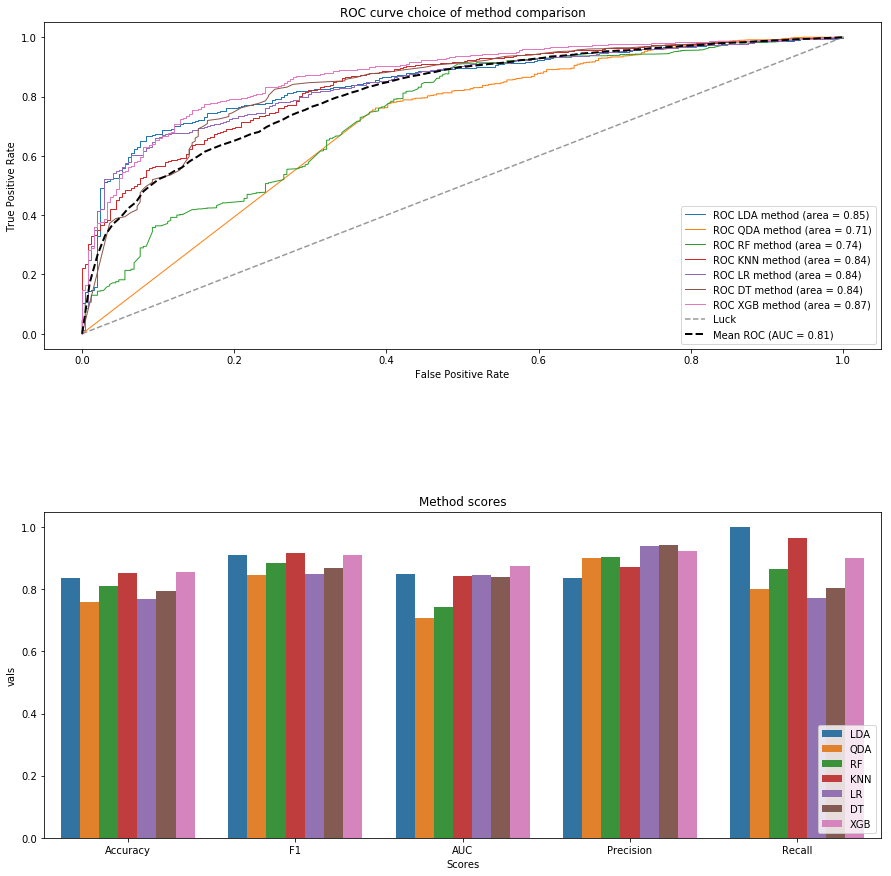

In [36]:
plot_all_methods(method_dict)

<span style="color:blue">
    Function to plot the confusion matrix of derived from a given method.
</span>

In [37]:
def plot_confusion_matrix(confusion_m, ax):
    target_names = ['Label 0', 'Label 1']
        
    ax.set_title('Confusion matrix')
    
    tick_marks = np.arange(len(target_names))
    ax.set_xlim([0., 1.])
    ax.set_ylim([0., 1.])
    ax.set_xticks(tick_marks, target_names)
    ax.set_yticks(tick_marks, target_names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    im = ax.imshow(confusion_m, interpolation='nearest', cmap=plt.get_cmap("Blues"))
    #plt.colorbar(im, cax=ax, orientation='horizontal')
    

<span style="color:blue">
    Functions to plot the roc auc curve and the precision vs. recall curves derived from the execution of a given classification method.
</span>

In [38]:
def plot_method_roc(fpr, tpr, method, ax):

    ax.plot(fpr, tpr, lw=1, label = method +' ROC')
    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(method + ' ROC AUC curve')
    ax.legend(loc="lower right")

    #ax.show() 
    
def plot_precision_and_recall_vs_threshold (pre, rec, thre, ax, method):
    ax.plot(thre, pre[:-1], "g-", label = "Precision")
    ax.plot(thre, rec[:-1], "b--", label = "Recall")
    ax.set_xlabel("Threshold")
    ax.legend(loc = "lower left")
    ax.set_ylim([0,1])
    ax.set_title(method + ' Precision-recall curve')

<span style="color:blue">
    Function to show the 3 plots (ROC AUC, Precision-recall and Confusion matrix) for all the methods tested.
</span>

In [39]:
def plot_method(methods): 
    
    sns.set(color_codes=True)
    figure = plt.figure(figsize=(20, 30))
    figure.subplots_adjust(wspace = 0.2, hspace = 0.4)
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["axes.titlesize"] = 15
    
    figure_rows = len(methods)

    element = 1
    for method, bparams in methods.items():
        ax_roc_auc = figure.add_subplot(figure_rows, 3, element)
        plot_method_roc(bparams['fpr'], bparams['tpr'], method, ax_roc_auc)
        element += 1
        
        ax_confusion = figure.add_subplot(figure_rows, 3, element)
        plot_precision_and_recall_vs_threshold(bparams['prec_c'], 
                                               bparams['recall_c'], bparams['thre_pc'], ax_confusion, method)
        element += 1

        ax_confusion = figure.add_subplot(figure_rows, 3, element)
        plot_confusion_matrix(bparams['conf_matrix'], ax_confusion)
        element += 1

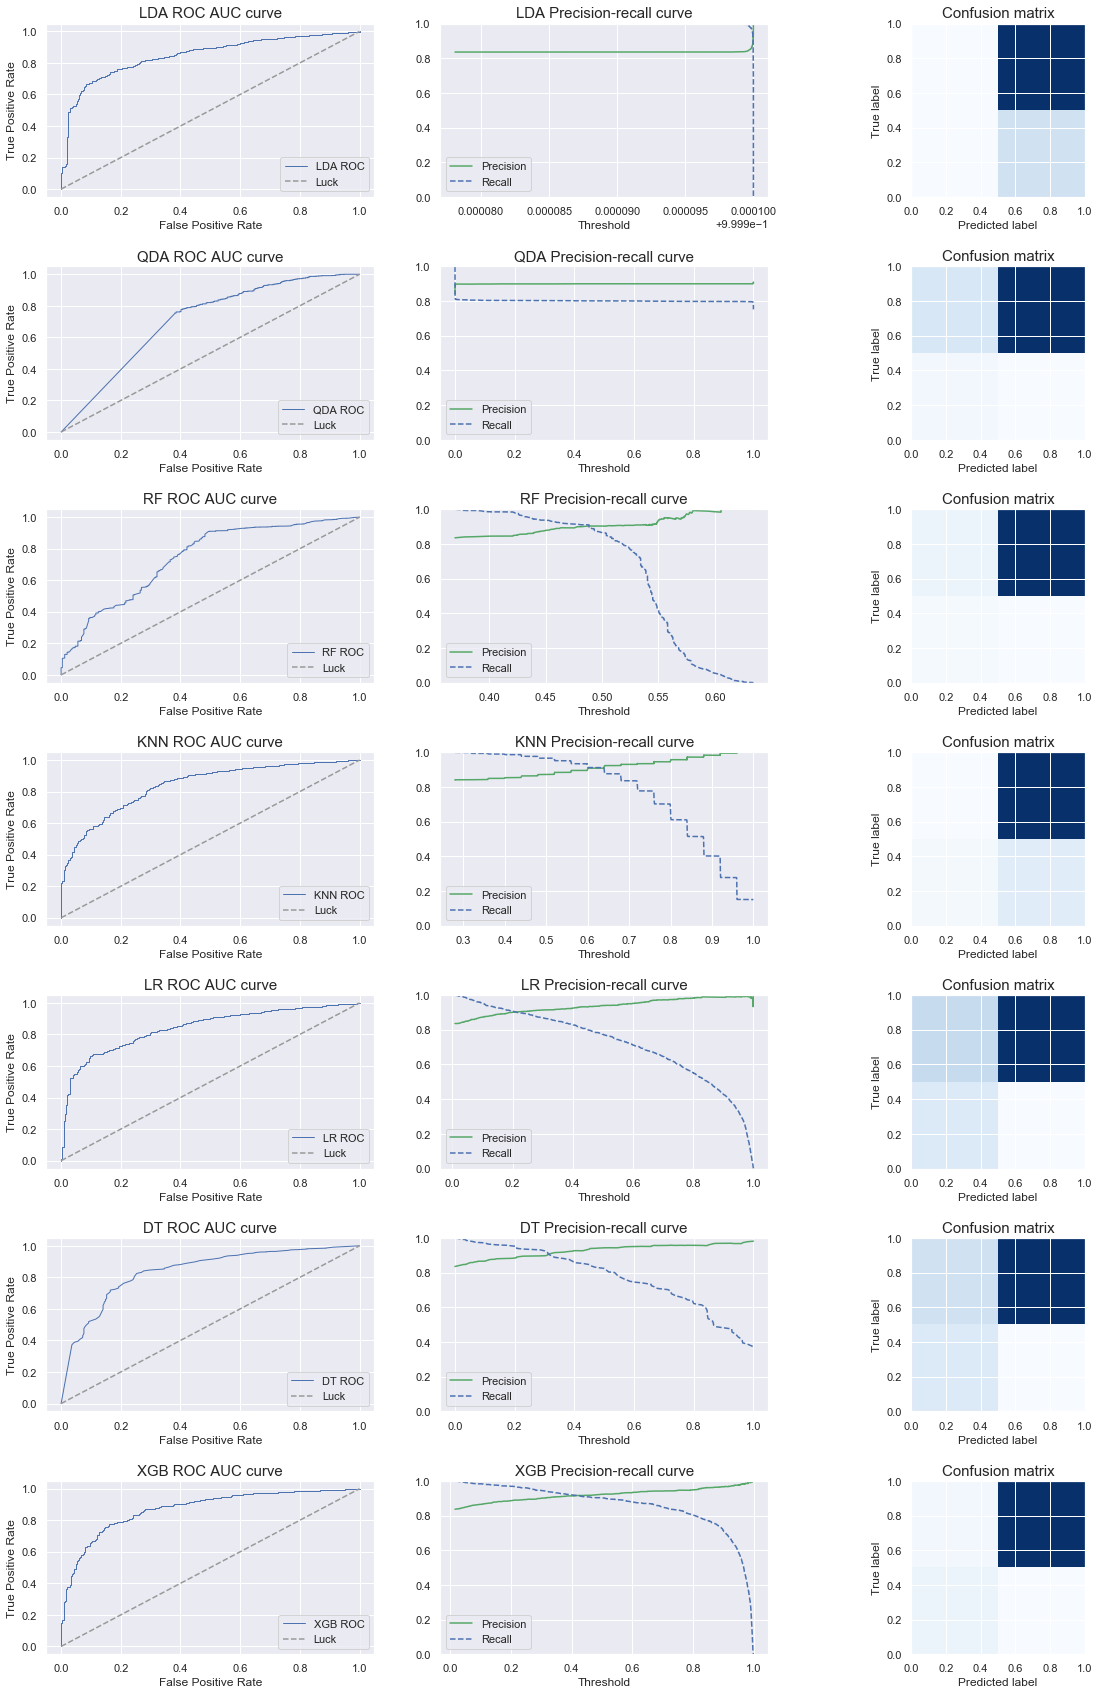

In [40]:
plot_method(method_dict)

#### ROC AUC and Confusion matrix

<span style="color:blue">
In the plot of “ROC curve choice of method comparison”, we found that the “area” value of these methods are: XGB method = 0.87, LDA method = 0.85, KNN method = 0.84, LR method = 0.84, DT method = 0.83, RF method = 0.78, and QDA method = 0.69. Therefore, we can conclude that, in terms of the ROC curve, the rank of classification quality from high to low is: XGB method > LDA method > KNN method > LR method > DT method > RF method > QDA method.<br><br>
In the plot of ”method scores”, according to the accuracy, ROC auc, precision, and recall values, LDA, KNN, RF and XGB generate relatively better classification for the given dataset compared to QDA, LR, and DT. This conclusion is consistent with the performance of these algorithms demonstrated in the confusion matrix.
</span>

#### Precision-recall

<span style="color:blue">
Precision is the accuracy of prediction. In other words, it is the ratio of true positive predictions to all positive predictions. Recall, which is also called sensitivity, is the ratio of true positive predictions to the sum of true positive predictions and false negative prediction. There is always a trade-off between precision and recall: increasing precision reduces recall, while increasing recall reduces precision. Therefore, we plot both the values of precision and recall as a function of threshold, which allows us to observe how the precision and recall change with threshold value.<br>
However, determining the optimal value for threshold depends on the datasets we are exploring. Due to the limited information about the meaning of the variables in the dataset, we do not have any preference on a high or low threshold.
</span>

# Trying PCA...

<span style="color:blue">
    We tried PCA as feature selection method. Considering the best 300 principal components (the number has been selected once we tested all the other methods), we tried to see how XGBoost would perform...<br>
    It was a little disappointing: even though the trained model perform very well in terms of ROC AUC, when sending the results for the test dataset, it performs way below the others. This is kind of expected, as the transformation of the features is based on the variance of the training observations, that can be really different in the case of the test dataset.
</span>

In [41]:
class PCASelector(TransformerMixin, BaseEstimator):
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X, y=None):
        self.pca = PCA(n_components=self.n_components, random_state=101).fit(X)
        return self

    def transform(self, X):
        x_transformed = self.pca.transform(X)
        
        df = pd.DataFrame(x_transformed)
        
        return df

In [42]:
def PCA_feature_selection(raw_df, categorical_columns, output_column, n_components, correlation_threshold):
    X, X_df, Y, Y_df = get_X_Y(raw_df, output_column)
   
    X_df = X_df.drop(categorical_columns, axis=1)

    wearable_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        #('high_correlation_selector', HighCorrelationSelector(correlation_threshold)),
        ('PCA_selector', PCASelector(n_components)),
    ])

    filtered_df = wearable_pipeline.fit_transform(X_df, Y)
    
    pca = wearable_pipeline.named_steps["PCA_selector"].pca
    
    print("PCA shape: ", filtered_df.shape)
    
    return filtered_df.join(Y_df), pca

In [34]:
n_components = 250

# First of all, exetute the feature selection using PCA
pca_featured_df, pca = PCA_feature_selection(train_wearable_raw_df, 
                                             categorical_columns, output_column, n_components, 0.89)

# After the feature selection, we add back the categorical features
#train_featured_df = pca_featured_df.join(train_wearable_raw_df[categorical_columns])
train_featured_df = pca_featured_df.join(train_wearable_raw_df[categorical_columns])

# We transform the categorical features into numerical features
ohe = OneHotEncoder(categorical_columns)
train_OHE_df = ohe.transform(train_featured_df)

# We test the dataset, using LDA
pca_best_classifier, bparam = test_classification_method(train_OHE_df, categorical_columns, output_column, 
                                                          "XGB", cutoff, thresholds, debug=False)

PCA shape:  (4584, 250)


In [35]:
# Function to execute a prediction of a test dataset, that has been previously transformed using a PCA scores
def write_prediction_PCA(train_df, test_df, best_clf, suffix, roc_auc):
    
    columns_to_drop = set(test_df.columns)-set(train_df.columns)
    test_df = test_df.drop(columns_to_drop, axis=1)
    
    preds = best_clf.predict_proba(test_df)

    # Convert the train and test matrix into a dataframes
    #Y_pred_df = pd.DataFrame(y_pred, columns=['output'])
    #Y_pred_df.index.names = ['id']
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%I%M%S%p")
    
    file_name = suffix + '_prediction_' + roc_auc + '_' + timestamp + '.csv'
    print("Writing file: " + file_name)
    
    #Y_pred_df.to_csv(file_name)
    
    submithis = pd.DataFrame([test_df.index,preds[:,1]]).T
    submithis.columns = ['id','output']
    submithis.id = submithis.id.astype(int)
    submithis.to_csv(file_name,index=False)

In [36]:
# Drop categorical features from test dataset
test_wearable_filtered_df = test_wearable_raw_df.drop(categorical_columns, axis=1)

print(test_wearable_filtered_df.shape)

# Transform test dataset, using the PCA previously built
test_data_transformed = pca.transform(test_wearable_filtered_df)
test_data_transformed_df = pd.DataFrame(test_data_transformed)

# Add back the categorical features, and transform them into numerical features
test_featured_df = test_data_transformed_df.join(test_wearable_raw_df[categorical_columns])
test_OHE_df = ohe.transform(test_featured_df)

# Execute prediction and write file
write_prediction_PCA(train_OHE_df, test_OHE_df, pca_best_classifier, "PCA_XGB", bparam['str_roc_auc'])

(1732, 666)
Writing file: PCA_XGB_prediction_0.85700_20181104_094954PM.csv
